In [222]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

DATA LOADING AND INITIAL ASSESSMENT

In [ ]:
house_data = pd.read_csv("Data/sberbank_housing.csv", index_col=0, low_memory=True)

# Drop non-predictive columns
house_data = house_data.drop(columns=["timestamp", "id"])

# Assess dataset dimensions and data quality
print(f"Original dataset shape: {house_data.shape}")
print(f"Dataset contains {house_data.shape[0]:,} transactions across {house_data.shape[1]} features")

# Comprehensive missing value analysis
print(f"\nMissing values per column:")
print(house_data.isnull().sum()) 

Original dataset shape: (27000, 18)
Dataset contains 27,000 transactions across 18 features

Missing values per column:
price_doc              0
full_sq                0
life_sq             5537
kitch_sq            9572
floor                167
max_floor           9572
build_year         12869
num_room            9572
state              13067
product_type           0
ecology                0
sub_area               0
raion_popul            0
kindergarten_km        0
school_km              0
park_km                0
railroad_km            0
metro_min_walk        14
dtype: int64


In [224]:
# Apply log transform to target (prices are heavily right-skewed)
house_data["price_doc"] = np.log1p(house_data["price_doc"])

# We checked that previously

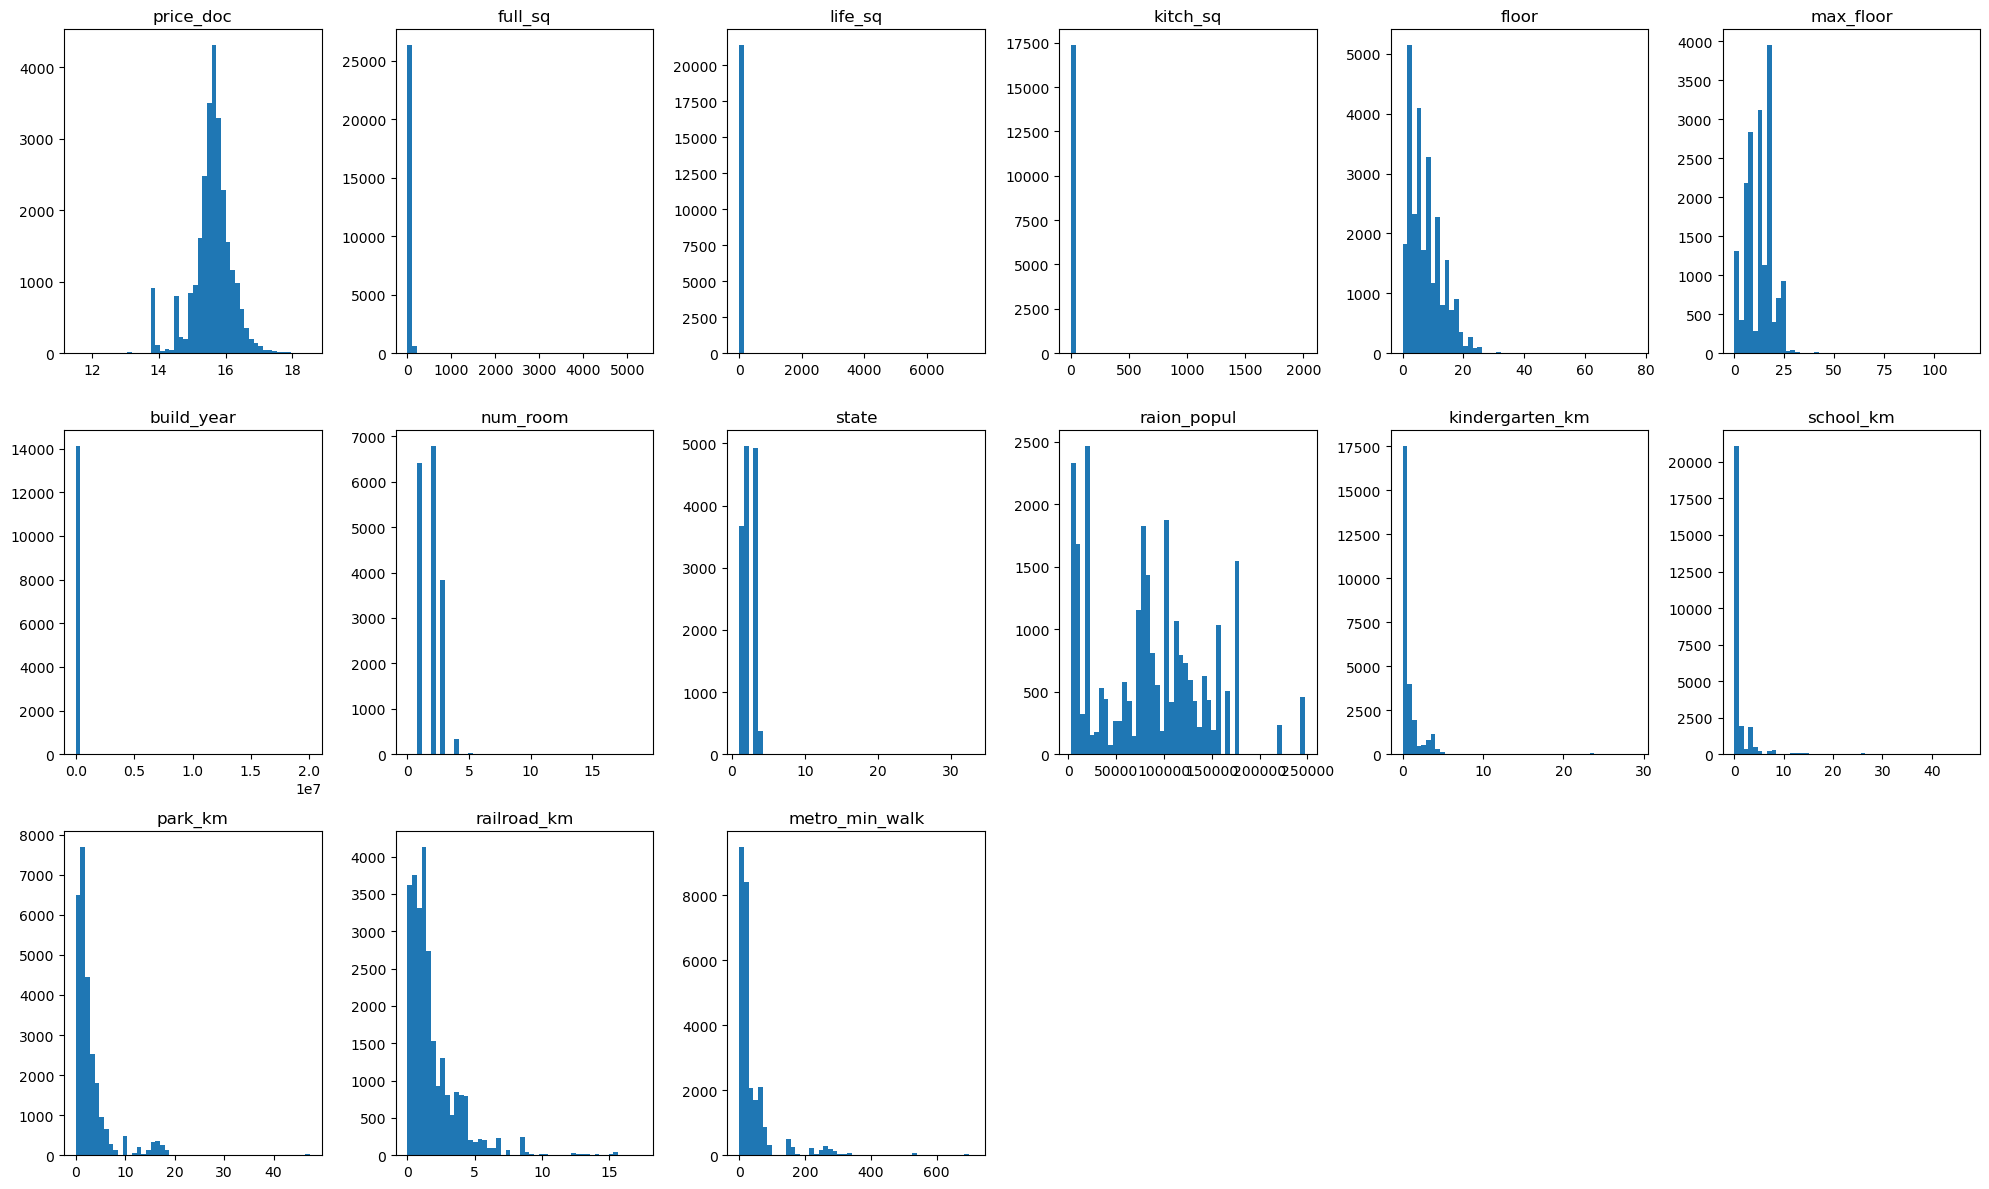

In [225]:
# Let's look at eth feature distributions

columns_to_inspect = house_data.select_dtypes(include=[np.number]).columns

# Let's look at histograms
nrows=3
ncols=6
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12))
axes_flat = axes.flatten()

for ax, col in zip(axes_flat, columns_to_inspect):
    
    ax.hist(house_data[col], bins=50)
    ax.set_title(col)
    
for ax in axes_flat[len(columns_to_inspect):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In [226]:
# Remove obvious errors and impossible values
house_data = house_data[house_data["full_sq"] <= 1200]  # Remove extreme outliers for full square footage
house_data = house_data[house_data["life_sq"] <= 1000] # Remove extreme outliers for living space square footage
house_data = house_data[house_data["kitch_sq"] <= 1000] # Remove extreme outliers for living space square footage
house_data = house_data[house_data["state"] < 10]
house_data = house_data[house_data["num_room"] <= 15]   # Remove impossible room counts
house_data = house_data[house_data["build_year"] > 1800]  # Remove impossible years
house_data = house_data.drop_duplicates()               # Remove duplicates

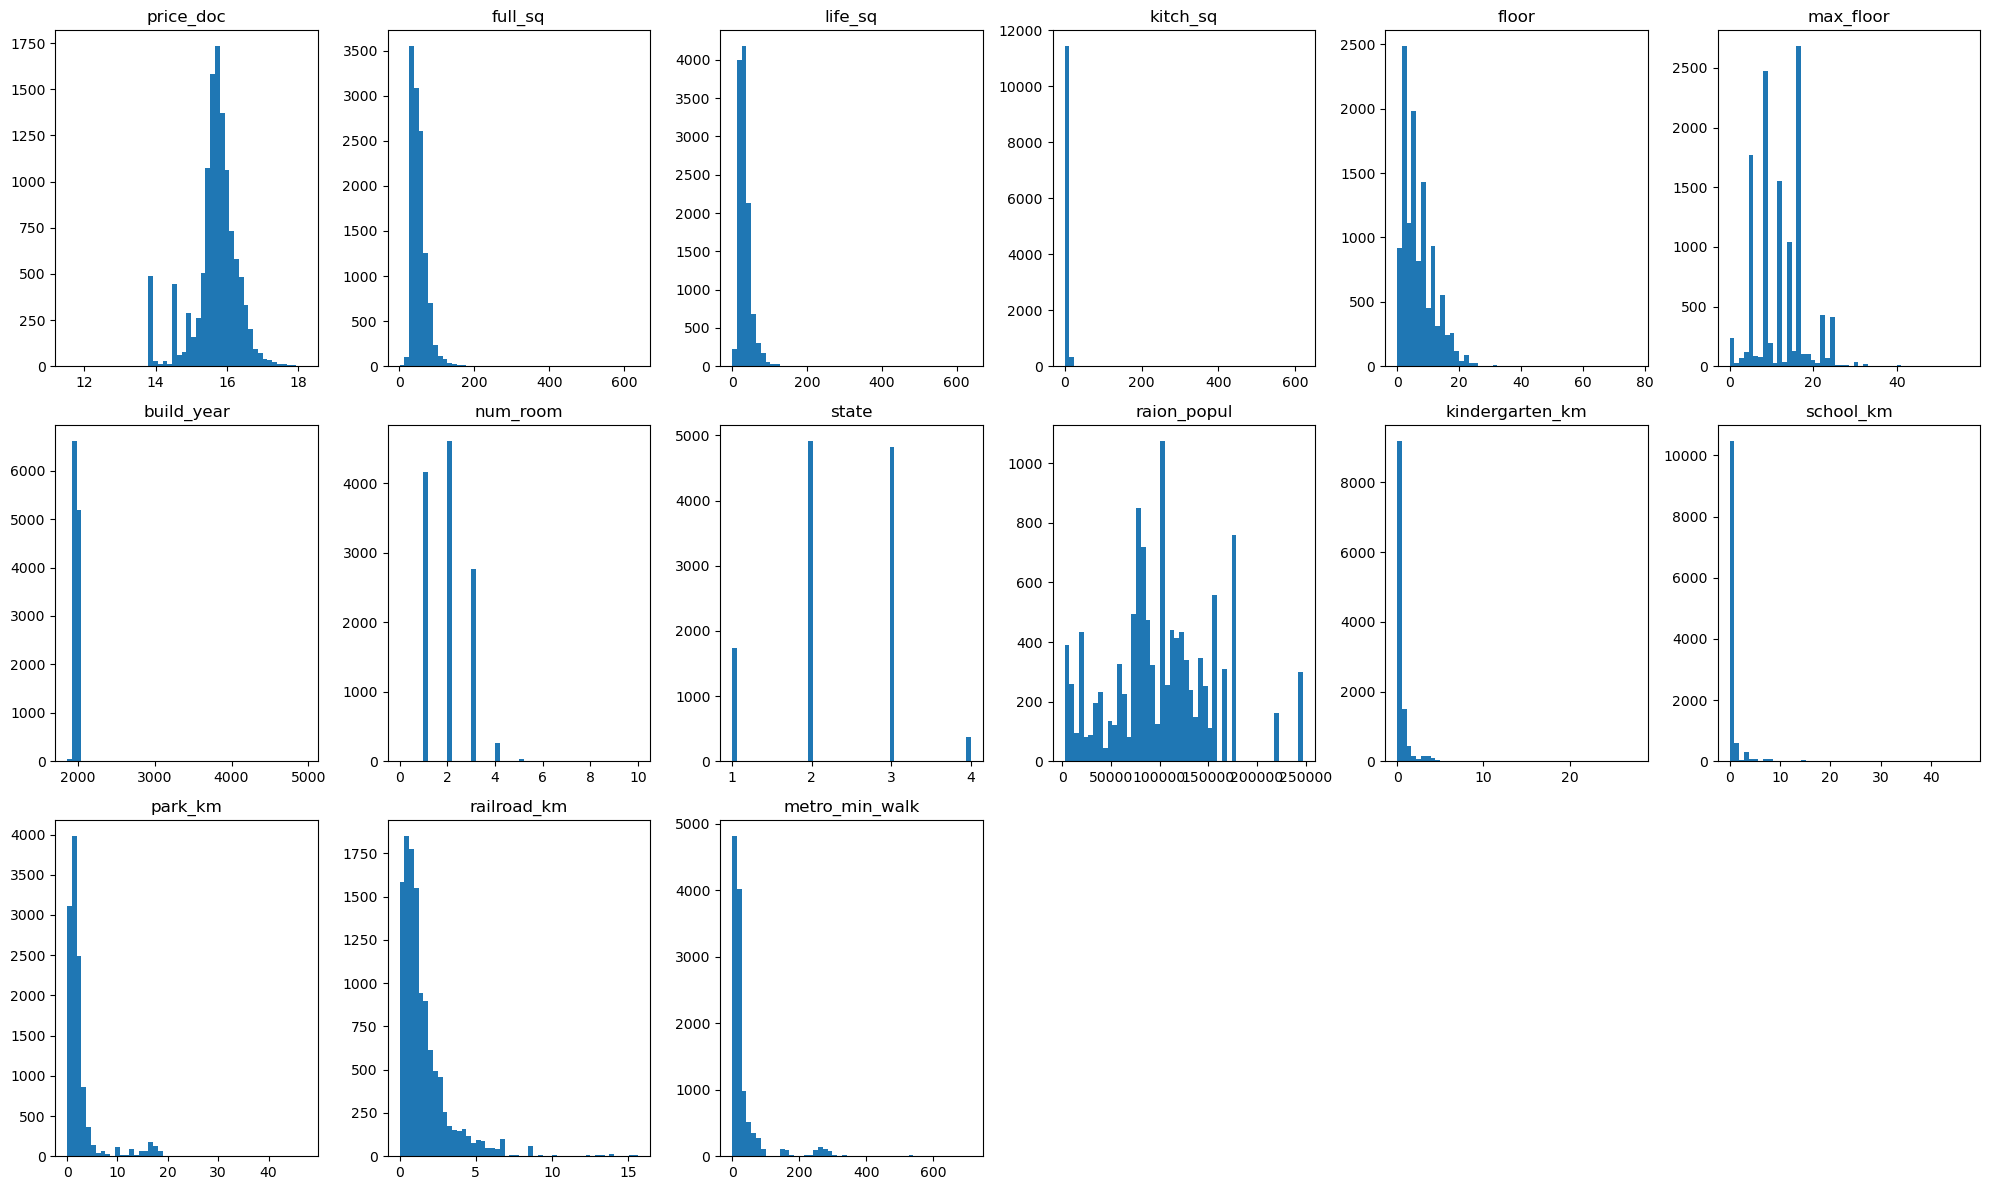

In [227]:
# Let's re-check the histograms
nrows=3
ncols=6
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12))
axes_flat = axes.flatten()

for ax, col in zip(axes_flat, columns_to_inspect):
    
    ax.hist(house_data[col], bins=50)
    ax.set_title(col)
    
for ax in axes_flat[len(columns_to_inspect):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

SPLIT DATA FIRST

In [228]:
X = house_data.drop("price_doc", axis=1)
y = house_data["price_doc"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (9460, 17)
Test set: (2366, 17)


FOCUSED PRACTICAL PREPROCESSING

The HybridImputer uses two different imputation strategies based on data type, because numeric and categorical missing values have different optimal solutions.

LEARNING PHASE (fit method):

Categorical - self.modes['sub_area'] = 'Downtown'  # Most common neighborhood

Numeric - Training data with missing 'life_sq' values --> KNN looks at similar houses to predict missing living space --> Finds 5 most similar houses by distance and averages their life_sq values

In [229]:
class HybridImputer(BaseEstimator, TransformerMixin):
    """KNN for numeric, mode for categorical"""
    
    def __init__(self):
        self.knn_imputer = KNNImputer(n_neighbors=5, weights="distance")
        self.modes = {}
        
    def fit(self, X, y=None):
        # Handle categorical first
        cat_cols = X.select_dtypes(include=['object']).columns
        for col in cat_cols:
            self.modes[col] = X[col].mode().iloc[0] if len(X[col].mode()) > 0 else 'unknown'
        
        # Fit KNN on numeric columns only
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            self.knn_imputer.fit(X[numeric_cols])
        
        return self
    
    def transform(self, X):
        X_work = X.copy()
        
        # Fill categorical with modes first
        for col, mode_val in self.modes.items():
            if col in X_work.columns:
                X_work[col] = X_work[col].fillna(mode_val)
        
        # KNN imputation for numeric
        numeric_cols = X_work.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            X_work[numeric_cols] = self.knn_imputer.transform(X_work[numeric_cols])
        
        return X_work

The SelectiveFeatureEngineer creates new, highly predictive features by combining existing raw features in meaningful ways. It's like a domain expert extracting insights that a model can't discover on its own

In [ ]:
class SelectiveFeatureEngineer(BaseEstimator, TransformerMixin):
    """Only the most impactful feature engineering"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_work = X.copy()
        epsilon = 1e-5
        
        # Only add features that are likely to be very predictive
        
        # 1. Living space efficiency (strong predictor of price per sqft)
        if 'life_sq' in X_work.columns and 'full_sq' in X_work.columns:
            X_work['living_efficiency'] = X_work['life_sq'] / (X_work['full_sq'] + epsilon)
        
        # 2. Room size (bigger rooms = luxury)
        if 'full_sq' in X_work.columns and 'num_room' in X_work.columns:
            X_work['avg_room_size'] = X_work['full_sq'] / (X_work['num_room'] + epsilon)
        
        # 3. Floor desirability (middle floors often preferred)
        if 'floor' in X_work.columns and 'max_floor' in X_work.columns:
            X_work['floor_ratio'] = X_work['floor'] / (X_work['max_floor'] + epsilon)
        
        # 4. Overall area (log transform to handle skewness)
        if 'full_sq' in X_work.columns:
            X_work['log_full_sq'] = np.log1p(X_work['full_sq'])
        
        # 5. Overall amenity accessibility score
        amenity_cols = ['kindergarten_km', 'school_km', 'park_km', 'metro_min_walk']
        available_amenities = [col for col in amenity_cols if col in X_work.columns]
        if len(available_amenities) >= 2:
            # Inverse distance (closer = higher score)
            X_work['amenity_score'] = sum(1 / (X_work[col] + epsilon) for col in available_amenities)
        
        return X_work

The SmartCategoricalEncoder automatically chooses the best encoding strategy based on each categorical variable's characteristics (cardnality)

In [231]:
class SmartCategoricalEncoder(BaseEstimator, TransformerMixin):
    """Effective categorical encoding without overcomplication"""
    
    def __init__(self):
        self.encodings = {}
        
    def fit(self, X, y=None):
        cat_cols = X.select_dtypes(include=['object']).columns
        
        for col in cat_cols:
            unique_vals = X[col].unique()
            
            if len(unique_vals) > 5:
                # Frequency encode sub_area (market activity indicator)
                freq_map = X[col].value_counts().to_dict()
                self.encodings[col] = ('frequency', freq_map)
            elif len(unique_vals) <= 5:
                # One-hot for low cardinality
                self.encodings[col] = ('onehot', unique_vals)
            else:
                # Ordinal for medium cardinality
                encoding_map = {val: i for i, val in enumerate(unique_vals)}
                self.encodings[col] = ('ordinal', encoding_map)
        
        return self
    
    def transform(self, X):
        X_work = X.copy()
        
        for col, (method, mapping) in self.encodings.items():
            if col not in X_work.columns:
                continue
                
            if method == 'frequency':
                X_work[col] = X_work[col].map(mapping).fillna(1)
            
            elif method == 'ordinal':
                X_work[col] = X_work[col].map(mapping).fillna(-1)
            
            elif method == 'onehot':
                # Simple one-hot encoding
                for val in mapping:
                    X_work[f"{col}_{val}"] = (X_work[col] == val).astype(int)
                X_work = X_work.drop(columns=[col])
        
        return X_work

FOCUSED PREPROCESSING PIPELINE

In [232]:
focused_preprocessor = Pipeline([
    ('imputer', HybridImputer()),
    ('feature_engineer', SelectiveFeatureEngineer()), 
    ('encoder', SmartCategoricalEncoder()),
    ('scaler', StandardScaler()) # Standardize all features after encoding
])

MODEL PIPELINE 

In [233]:
# Create model pipeline
model_pipeline = Pipeline([
    ('preprocessor', focused_preprocessor),
    ('regressor', Ridge(alpha=10.0, random_state=42))
])

FIT THE PREPROCESSING PIPELINE

In [234]:
print("Fitting advanced preprocessing pipeline...")
model_pipeline.fit(X_train, y_train)

# Make predictions
test_pred = model_pipeline.predict(X_test)

# Calculate metrics
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

Fitting advanced preprocessing pipeline...


In [235]:
# Identify column types for reporting
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

In [236]:
print(f"   Test RMSE: {test_rmse:.3f} (log scale)")

print("\n" + "="*60)
print("ADVANCED PREPROCESSING BENEFITS:")
print("="*60)
print("✓ Handles missing values (median/mode imputation)")
print("✓ Converts categorical data to numeric (smart encoding)")
print("✓ Creates new predictive features (feature engineering)")
print("✓ Standardizes feature scales") 
print("✓ Uses ALL available features (not just complete numeric)")
print("✓ Prevents data leakage (fit only on training data)")
print("✓ Robust to new data (handles unseen categories)")
print("✓ Focused feature engineering (avoids overfitting)")

   Test RMSE: 0.502 (log scale)

ADVANCED PREPROCESSING BENEFITS:
✓ Handles missing values (median/mode imputation)
✓ Converts categorical data to numeric (smart encoding)
✓ Creates new predictive features (feature engineering)
✓ Standardizes feature scales
✓ Uses ALL available features (not just complete numeric)
✓ Prevents data leakage (fit only on training data)
✓ Robust to new data (handles unseen categories)
✓ Focused feature engineering (avoids overfitting)


In [237]:
# # Calculate residuals
# residuals = y_test - test_pred

# # 1. Check homoscedasticity
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.scatter(test_pred, residuals, alpha=0.6)
# plt.xlabel("Fitted Values (Predictions)")
# plt.ylabel("Residuals")
# plt.title("Residuals vs Fitted")
# plt.axhline(y=0, color='red', linestyle='--')

# # 2. Check normality of residuals
# plt.subplot(1, 2, 2)
# from scipy import stats
# stats.probplot(residuals, dist="norm", plot=plt)
# plt.title("Q-Q Plot - Residual Normality")

# plt.tight_layout()
# plt.show()

Let's compare the results (by converting log scale to $ scale)

In [238]:
with open("baseline_rmse.txt", "r") as f:
    baseline_rmse_dollars = float(f.read().strip())
    
# Convert back to dollar scale for interpretation
test_pred_dollars = np.expm1(test_pred)
y_test_dollars = np.expm1(y_test)

test_rmse_dollars = np.sqrt(mean_squared_error(y_test_dollars, test_pred_dollars))

In [239]:
percent_improvement = (baseline_rmse_dollars - test_rmse_dollars) / baseline_rmse_dollars * 100
print(f"\nPercentage improvement over baseline: {percent_improvement:.2f}%")


Percentage improvement over baseline: 27.30%
